<a href="https://colab.research.google.com/github/chanon9945/RIIC_demo/blob/main/RIIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import random
from itertools import combinations
import io

In [57]:
!pip install deap
from deap import base, creator, tools, algorithms

In [100]:
!wget https://github.com/chanon9945/RIIC_demo/raw/refs/heads/main/entry1.csv -O entry1.csv

--2025-03-09 15:38:41--  https://github.com/chanon9945/RIIC_demo/raw/refs/heads/main/entry1.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chanon9945/RIIC_demo/refs/heads/main/entry1.csv [following]
--2025-03-09 15:38:41--  https://raw.githubusercontent.com/chanon9945/RIIC_demo/refs/heads/main/entry1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5543 (5.4K) [text/plain]
Saving to: ‘entry1.csv’

entry1.csv          100%[===================>]   5.41K  --.-KB/s    in 0s      

2025-03-09 15:38:41 (49.4 MB/s) - ‘entry1.csv’ saved [5543/5543]



In [101]:
entry = pd.read_csv('entry1.csv')
entry.head()

,name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
0,Alice Smith,Female,Heterosexual,"reading, traveling, cooking",soccer,Taylor Swift,28,New York,Bachelor,Single
1,Bob Johnson,Male,Heterosexual,"gaming, sports, hiking",basketball,Drake,32,Los Angeles,Bachelor,Married
2,Carol Williams,Female,Heterosexual,"painting, photography",tennis,Adele,25,Chicago,Master,Single
3,David Brown,Male,Heterosexual,"cooking, traveling, reading",baseball,The Beatles,45,Houston,High School,Married
4,Emily Jones,Female,Heterosexual,"dancing, music, traveling",running,Lady Gaga,30,Phoenix,Bachelor,In a relationship


In [102]:
def create_passage(row):
    """
    Constructs a passage string from a row of data.

    Expects the row to have the following keys:
    'name', 'gender', 'sexual_orientation', 'hobbies',
    'favorite_sports', 'favorite_musician', 'age', 'city',
    'education_level', 'relationship_status'
    """
    passage = (
        f"{row['name']} is a {row['age']}-year-old {row['gender']} with a {row['sexual_orientation']} orientation. "
        f"They enjoy {row['hobbies']}, and their favorite sport is {row['favorite_sports']}. "
        f"They love listening to {row['favorite_musician']} and live in {row['city']}. "
        f"Education level: {row['education_level']}, Relationship status: {row['relationship_status']}."
    )
    return passage

In [103]:
#combine the entry as strings
passage_entry = []
for index, row in entry.iterrows():
  passage_entry.append(create_passage(row))

In [104]:
#embed the strings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(passage_entry)

In [105]:
#calculate the dot product and store as a matrix
dot_product_matrix = np.dot(embeddings, embeddings.T)/2

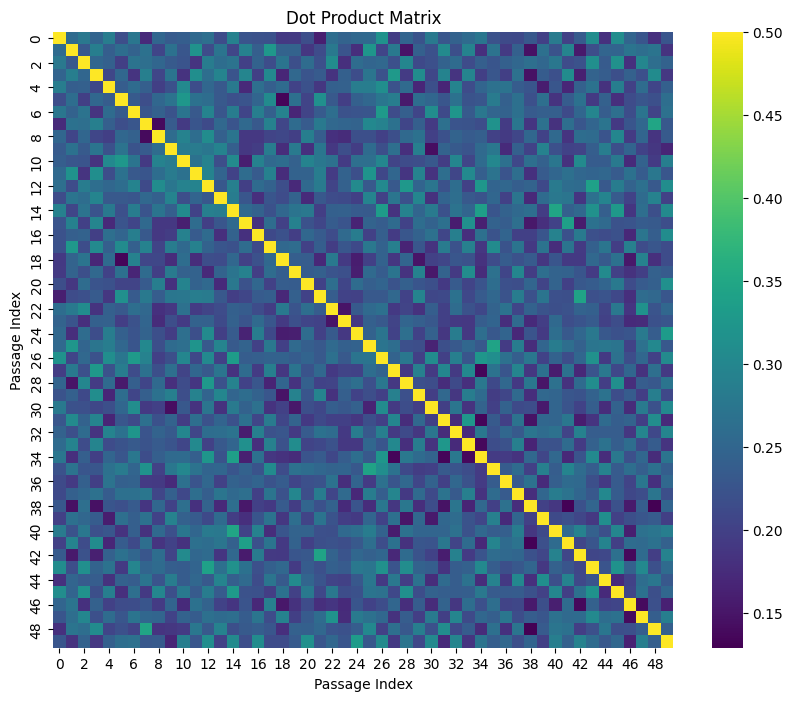

In [106]:
#plot the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(dot_product_matrix, cmap='viridis', annot=False)
plt.title("Dot Product Matrix")
plt.xlabel("Passage Index")
plt.ylabel("Passage Index")
plt.show()

In [107]:
n = dot_product_matrix.shape[0] #number of individuals
group_size = 5
num_groups = n // group_size  # should be 10 groups

def evaluate_partition(individual):
    total_similarity = 0
    for i in range(num_groups):
        group = individual[i * group_size : (i + 1) * group_size]
        for a, b in combinations(group, 2):
            total_similarity += dot_product_matrix[a, b]
    return total_similarity,

# Create fitness and individual types (maximization)
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Each individual is a random permutation of all n individuals
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: random.sample(range(n), n))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_partition)
toolbox.register("select", tools.selTournament, tournsize=3)
# Use a built-in ordered crossover which is suited for permutation problems
toolbox.register("mate", tools.cxOrdered)
# Use a mutation that shuffles a subset of indices
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)

# Create an initial population
population = toolbox.population(n=50)

# GA parameters
NGEN = 40
CXPB = 0.7  # Crossover probability
MUTPB = 0.2  # Mutation probability

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = list(map(toolbox.evaluate, offspring))

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

# Extract the best individual (partition)
best_individual = tools.selBest(population, k=1)[0]
best_fitness = toolbox.evaluate(best_individual)[0]

print("Best partition (all 10 groups):")
for i in range(num_groups):
    group = best_individual[i * group_size : (i + 1) * group_size]
    print(f"Group {i + 1}: {group}")

print("Maximum total similarity:", best_fitness)

Best partition (all 10 groups):
Group 1: [18, 33, 1, 37, 4]
Group 2: [26, 23, 40, 0, 45]
Group 3: [39, 27, 24, 3, 36]
Group 4: [47, 43, 2, 25, 22]
Group 5: [34, 16, 49, 21, 38]
Group 6: [9, 10, 11, 20, 29]
Group 7: [31, 17, 7, 48, 13]
Group 8: [5, 44, 35, 15, 19]
Group 9: [28, 30, 42, 8, 12]
Group 10: [32, 14, 6, 41, 46]
Maximum total similarity: 25.636641576886177


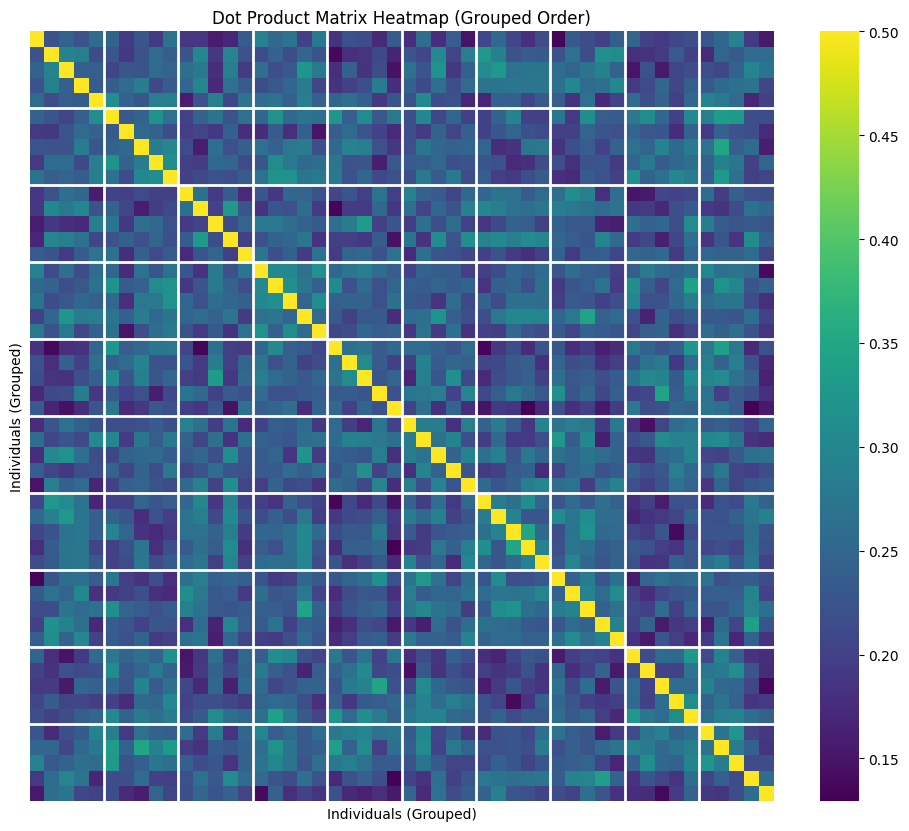

In [108]:
# Reorder the dot product matrix using the best partition ordering
ordered_indices = best_individual  # best_individual is a list of 50 indices
ordered_matrix = dot_product_matrix[np.ix_(ordered_indices, ordered_indices)]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ordered_matrix, cmap='viridis', annot=False, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title("Dot Product Matrix Heatmap (Grouped Order)")
plt.xlabel("Individuals (Grouped)")
plt.ylabel("Individuals (Grouped)")

# Optionally, add lines to visually separate groups (every 5 rows/columns)
for i in range(1, num_groups):
    plt.axhline(i * group_size, color='white', lw=2)
    plt.axvline(i * group_size, color='white', lw=2)

plt.show()

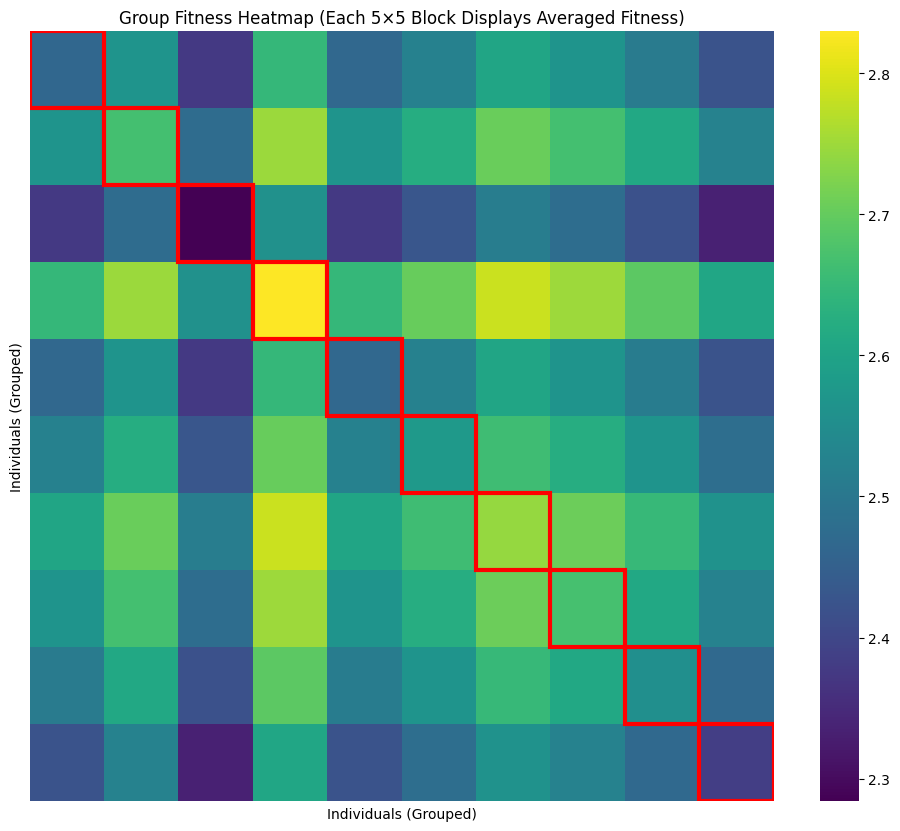

In [112]:
# Define an evaluation function that computes the total similarity for a group,
# using the ordered matrix. Here, group_indices are indices within the ordered_matrix.
def evaluate_group_from_ordered_matrix(group_indices):
    total_similarity = 0
    for i, j in combinations(group_indices, 2):
        total_similarity += ordered_matrix[i, j]
    return total_similarity

# Compute the fitness (total similarity) for each group in the ordered matrix.
# In the ordered matrix, groups are contiguous. For group i, the indices are:
# [i*group_size, i*group_size+1, ..., (i+1)*group_size - 1]
group_fitnesses = []
for i in range(num_groups):
    group_indices = list(range(i * group_size, (i + 1) * group_size))
    fitness_val = evaluate_group_from_ordered_matrix(group_indices)
    group_fitnesses.append(fitness_val)
group_fitnesses = np.array(group_fitnesses)  # shape: (10,)

# Create a 10x10 block matrix where each block (i, j) is the average of
# group i and group j fitness values.
block_matrix = np.zeros((num_groups, num_groups))
for i in range(num_groups):
    for j in range(num_groups):
        block_matrix[i, j] = (group_fitnesses[i] + group_fitnesses[j]) / 2

# Expand the 10x10 block matrix to a 50x50 matrix.
# Each cell in block_matrix becomes a group_size x group_size block with the same value.
full_heatmap = np.kron(block_matrix, np.ones((group_size, group_size)))

# Plot the heatmap without annotations.
plt.figure(figsize=(12, 10))
ax = sns.heatmap(full_heatmap, cmap='viridis', annot=False, cbar=True,
                 xticklabels=False, yticklabels=False)
plt.title("Group Fitness Heatmap (Each 5×5 Block Displays Averaged Fitness)")
plt.xlabel("Individuals (Grouped)")
plt.ylabel("Individuals (Grouped)")

# Highlight each diagonal 5x5 block with a red border.
for i in range(num_groups):
    x = i * group_size
    y = i * group_size
    rect = plt.Rectangle((x, y), group_size, group_size, fill=False, edgecolor='red', lw=3)
    ax.add_patch(rect)

plt.show()

In [87]:
group_csvs = {}

for i in range(num_groups):
    group_indices = best_individual[i * group_size : (i + 1) * group_size]
    group_df = entry.iloc[group_indices].reset_index(drop=True)
    csv_text = group_df.to_csv(index=False)
    group_csvs[f"Group_{i+1}"] = csv_text
    print(f"Group {i+1}:")
    print(csv_text)
    print("-" * 40)

Group 1:
name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
Susan Jackson,Female,Homosexual,"cooking, dancing, reading",tennis,Adele,35,Dallas,Bachelor,Single
Tom Martin,Male,Heterosexual,"sports, gaming, music",football,Ed Sheeran,28,San Jose,Bachelor,In a relationship
Harry Scott,Male,Heterosexual,"sports, gaming, hiking",baseball,Ed Sheeran,38,Houston,High School,Single
Leo Adams,Male,Heterosexual,"traveling, cooking, sports",baseball,The Beatles,43,San Diego,High School,Married
Noah Nelson,Male,Heterosexual,"gaming, sports, traveling",football,Ed Sheeran,35,San Jose,Bachelor,Married

----------------------------------------
Group 2:
name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
Nathan Wilson,Male,Heterosexual,"traveling, music, sports",baseball,The Beatles,38,Houston,High School,Single
Patrick Mitchell,Male,Heterosexual,"sports, gaming, hiking",

In [97]:
group1_csv = group_csvs["Group_1"]
group1_df = pd.read_csv(io.StringIO(group1_csv))
group1_df.head()

,name,gender,sexual_orientation,hobbies,favorite_sports,favorite_musician,age,city,education_level,relationship_status
0,Susan Jackson,Female,Homosexual,"cooking, dancing, reading",tennis,Adele,35,Dallas,Bachelor,Single
1,Tom Martin,Male,Heterosexual,"sports, gaming, music",football,Ed Sheeran,28,San Jose,Bachelor,In a relationship
2,Harry Scott,Male,Heterosexual,"sports, gaming, hiking",baseball,Ed Sheeran,38,Houston,High School,Single
3,Leo Adams,Male,Heterosexual,"traveling, cooking, sports",baseball,The Beatles,43,San Diego,High School,Married
4,Noah Nelson,Male,Heterosexual,"gaming, sports, traveling",football,Ed Sheeran,35,San Jose,Bachelor,Married
